In [130]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import matplotlib.pyplot as plt
import numpy as np
# ---- 한글 폰트 설정 ----
# (Windows) 보통 'Malgun Gothic'
plt.rc('font', family='Malgun Gothic')  
# (Mac) 보통 'AppleGothic'
# plt.rc('font', family='AppleGothic')
# (Linux, Colab) 나눔글꼴 경로 지정 필요할 수 있음
# plt.rc('font', family='NanumGothic')

plt.rc('axes', unicode_minus=False)  # 마이너스 기호 깨짐 방지

# sliding 데이터 불러오기

In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", font="Malgun Gothic")

df = pd.read_csv("../data/processed/train_sliding_sales.csv", encoding="utf-8")
df_new = pd.read_csv("../data/processed/test_sliding_sales.csv", encoding="utf-8")



- nan 발견됨, 일단 행을 제거

# set1 불러와서 상권, 업종 붙이기

In [132]:

from __future__ import annotations
import re
import unicodedata
import numpy as np
import pandas as pd

# =========================================================
# 공통 유틸
# =========================================================

def try_read_csv(path: str) -> pd.DataFrame:
    """인코딩 오류 방지용 CSV 로드 함수"""
    for enc in ["utf-8-sig", "cp949", "euc-kr", "utf-8"]:
        try:
            return pd.read_csv(path, encoding=enc)
        except Exception:
            continue
    return pd.read_csv(path, engine="python", encoding_errors="ignore")

def normalize_str(x) -> str | float:
    """문자 표준화(유니코드/공백)"""
    if pd.isna(x):
        return np.nan
    s = unicodedata.normalize("NFKC", str(x))
    s = re.sub(r"\s+", " ", s).strip()
    return s

def parse_yyyymmdd(series: pd.Series) -> pd.Series:
    s = series.astype(str).str.strip()
    bad = {"nan","NaN","NULL","None","",".", " "}
    s = s.apply(lambda x: np.nan if x in bad else x)
    s = s.str.replace(r"\.", "", regex=True)       # 점 제거
    s = s.str.replace(r"\D", "", regex=True)       # 숫자만
    s = s.str.slice(0, 8)                          # 8자리 제한
    return pd.to_datetime(s, format="%Y%m%d", errors="coerce")

def clean_category(series: pd.Series, default_label="기타") -> pd.Series:
    """카테고리 통일 + 의심값 → '기타'"""
    na_tokens = {"nan","nat","none","null","","-",".","미정","미상","무응답","없음"}
    s = series.map(normalize_str)
    mask_bad = s.str.lower().isin(na_tokens)
    return s.where(~mask_bad, default_label).fillna(default_label).astype("category")


In [133]:
import numpy as np
import pandas as pd

# =========================================================
# Set1: 점포 메타 (업종 통합 매핑 - 딕셔너리 기반 직접 매핑 버전)
#  - 입력 CSV를 rename_info(영문 스키마)로 리네임
#  - 날짜 파싱, 카테고리 클린, 업종 통합, 상권 정리, 폐업 라벨 등 생성
#  - 반환: (df, closed_codes)  # closed_codes는 num 배열
# 필요 유틸:
#   - try_read_csv(path)      : CSV 로더
#   - parse_yyyymmdd(Series)  : YYYYMMDD/문자열→datetime 변환
#   - clean_category(Series)  : 카테고리 문자열 정리
# =========================================================
def load_set1(path: str, cutoff: str = "2024-12-31") -> tuple[pd.DataFrame, np.ndarray]:
    df = try_read_csv(path).copy()
    df.columns = [c.strip() for c in df.columns]

    # 1) 원본 → 영문 표준 스키마 리네임
    rename_info = {
        "ENCODED_MCT": "num",        # 가맹점ID
        "MCT_BSE_AR": "addr",        # 주소
        "MCT_NM": "name",            # 가맹점명
        "MCT_BRD_NUM": "brand_cd",   # 브랜드코드
        "MCT_SIGUNGU_NM": "sigungu", # 지역(시군구)
        "HPSN_MCT_ZCD_NM": "biz_type",  # 업종
        "HPSN_MCT_BZN_CD_NM": "market", # 상권
        "ARE_D": "open",             # 개설일
        "MCT_ME_D": "close"          # 폐업일
    }
    for k, v in rename_info.items():
        if k in df.columns:
            df = df.rename(columns={k: v})

    # 2) 날짜 변환
    if "open" in df.columns:
        df["open"] = parse_yyyymmdd(df["open"])
    else:
        df["open"] = pd.NaT

    if "close" in df.columns:
        df["close"] = parse_yyyymmdd(df["close"])
    else:
        df["close"] = pd.NaT

    # 3) 파생/클린 (영문 표준 컬럼 기준)
    df["biz_type"] = clean_category(df.get("biz_type", pd.Series(dtype=object)))
    df["market"]   = clean_category(df.get("market",   pd.Series(dtype=object)))

    # 프랜차이즈 여부 (브랜드코드 존재여부)
    df["is_franchise"] = df.get("brand_cd", pd.Series(index=df.index)).notna().astype(int)

    # 4) 업종 통합 매핑
    groups = {
        # 한식 계열
        "한식": [
            "한식-단품요리일반", "백반/가정식", "기사식당", "한식뷔페",
            "한식-국밥/설렁탕", "한식-찌개/전골", "한식-감자탕", "한식-죽", "한정식", "한식-두부요리",
            "한식-국수/만두", "한식-냉면",
            "한식-육류/고기", "한식-해물/생선"
        ],
        # 중식 계열
        "중식 음식점업": ["중식당", "중식-훠궈/마라탕", "중식-딤섬/중식만두"],
        # 일식 계열
        "일식 음식점업": [
            "일식당", "이자카야", "꼬치구이",
            "일식-덮밥/돈가스", "일식-우동/소바/라면",
            "일식-샤브샤브", "일식-초밥/롤", "일식-참치회"
        ],
        # 서양/외국식 계열
        "서양식 음식점업": ["양식", "스테이크"],
        "기타 외국식 음식점업": ["동남아/인도음식", "기타세계요리"],
        # 패스트푸드/간편식
        "피자·햄버거·샌드위치 및 유사음식점업": ["피자", "햄버거", "샌드위치/토스트"],
        "치킨전문점": ["치킨"],
        "김밥 및 기타 간이 음식점업": ["분식"],
        "간이 음식 포장 판매 전문점": ["도시락", "반찬"],
        # 제과/디저트 계열
        "제과점": ["베이커리", "도너츠", "떡/한과", "떡/한과 제조", "마카롱", "와플/크로플", "아이스크림/빙수", "탕후루"],
        # 커피/음료 계열
        "커피 전문점": ["카페", "커피전문점", "테이크아웃커피", "테마카페"],
        "기타 비알코올 음료점업": ["주스", "차"],
        # 주점 계열 (통합)
        "주점업": [
            "호프/맥주", "일반 유흥주점", "룸살롱/단란주점",
            "요리주점", "포장마차", "민속주점", "와인바", "와인샵", "주류"
        ],
        # 구내식당
        "기관 구내식당업": ["구내식당/푸드코트"],
        # 기타 식료품/담배 등
        "기타": [
            "농산물", "청과물", "인삼제품", "건강식품", "식품 제조", "미곡상",
            "식료품", "축산물", "담배", "건강원", "수산물", "건어물", "유제품"
        ],
    }
    reverse_map = {raw: merged for merged, raws in groups.items() for raw in raws}

    # 통합 라벨 (한글 파생 컬럼 유지)
    df["biz_type_adj"] = (
        df["biz_type"].astype("string").str.strip().map(reverse_map).fillna(df["biz_type"])
    )
    df["biz_type_adj"] = (
        df["biz_type_adj"].astype(str).str.replace(r"\s+", "", regex=True).str.strip()
    )

    # 5) 상권 정리 (희소 상권 = '상권없음')
    sk = df["market"].astype(str).str.strip().replace({"nan": np.nan})
    counts = sk.value_counts(dropna=False)
    freq = sk.map(counts).fillna(0)
    df["market_adj"] = sk.where(freq > 1, other="상권없음").fillna("상권없음").astype("category")

    # open 결측 제거
    df = df[df["open"].notna()].copy()

    # 형식 조금 정리(선택)
    df["biz_type_adj"] = df["biz_type_adj"].astype("category")

    return df


In [134]:
# 파일 경로 지정 (상대경로나 절대경로 사용 가능)
path = "../data/raw/big_data_set1_f.csv"   # 예시: data/raw 폴더 안에 set1.csv가 있을 때

# 함수 실행
set1 = load_set1(path)

# 확인
print(set1.head())           # 전처리된 set1 일부 확인
print(set1.info())            # 행/열 크기 확인


          num        addr  name brand_cd sigungu biz_type market       open  \
0  16184E93D9  서울 성동구 마장동  성우**      NaN  서울 성동구      축산물    마장동 2013-03-20   
1  4D039EA8B7  서울 성동구 마장동  대보**      NaN  서울 성동구      축산물    마장동 2013-11-22   
2  0074C4990A  서울 성동구 마장동  대용**      NaN  서울 성동구      축산물    마장동 2014-05-12   
3  68308F2746  서울 성동구 마장동  통일**      NaN  서울 성동구      축산물    마장동 2015-11-24   
4  4117EDDE9C  서울 성동구 마장동  한울**      NaN  서울 성동구      축산물    마장동 2015-12-11   

  close  is_franchise biz_type_adj market_adj  
0   NaT             0           기타        마장동  
1   NaT             0           기타        마장동  
2   NaT             0           기타        마장동  
3   NaT             0           기타        마장동  
4   NaT             0           기타        마장동  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4185 entries, 0 to 4184
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   num           4185 non-nu

In [135]:
# df: 분석용 메인 데이터셋 (num 포함)
# set1: load_set1()에서 반환된 DataFrame

df = df.merge(
    set1[["num", "market_adj", "biz_type_adj"]],
    on="num",
    how="left"
)


# 확인
print(df[["num", "market_adj", "biz_type_adj"]].head())


          num market_adj biz_type_adj
0  000F03E44A         뚝섬       중식음식점업
1  000F03E44A         뚝섬       중식음식점업
2  000F03E44A         뚝섬       중식음식점업
3  000F03E44A         뚝섬       중식음식점업
4  000F03E44A         뚝섬       중식음식점업


In [136]:
# df: 분석용 메인 데이터셋 (num 포함)
# set1: load_set1()에서 반환된 DataFrame

df_new = df_new.merge(
    set1[["num", "market_adj", "biz_type_adj"]],
    on="num",
    how="left"
)


# 확인
print(df_new[["num", "market_adj", "biz_type_adj"]].head())


          num market_adj biz_type_adj
0  000F03E44A         뚝섬       중식음식점업
1  000F03E44A         뚝섬       중식음식점업
2  000F03E44A         뚝섬       중식음식점업
3  002816BA73        마장동          주점업
4  002816BA73        마장동          주점업


# GMM 클러스터

## 전처리

In [137]:
# 모든 컬럼 보이도록 설정
pd.set_option("display.max_columns", None)
# 모든 행 다 보이게
pd.set_option("display.max_rows", None)

print(list(df.columns))

# (원래대로 되돌리려면 None 대신 기본값 20 같은 숫자를 넣으면 돼요)


['num', 'biz_type', 'market', 'is_franchise', 'open', 'is_cold_start', 'is_market_missing', 'base_ym', 'target_ym', 'y', 'oper_month_grp_mean', 'sales_grp_mean', 'txn_cnt_grp_mean', 'cust_cnt_grp_mean', 'avg_pay_grp_mean', 'cancel_rate_grp_mean', 'delivery_sales_ratio_mean', 'rel_sales_ratio_mean', 'M1_SME_RY_CNT_RAT_mean', 'sales_rank_industry_mean', 'sales_rank_market_mean', 'share_sales_industry_mean', 'share_sales_market_mean', 'male_20below_ratio_mean', 'male_30_ratio_mean', 'male_40_ratio_mean', 'male_50_ratio_mean', 'male_60plus_ratio_mean', 'female_20below_ratio_mean', 'female_30_ratio_mean', 'female_40_ratio_mean', 'female_50_ratio_mean', 'female_60plus_ratio_mean', 'revisit_ratio_mean', 'new_ratio_mean', 'resident_ratio_mean', 'worker_ratio_mean', 'floating_ratio_mean', 'sales_estimate_mean', 'is_customer_missing_mean', 'is_behavior_missing_mean', 'is_type_missing_mean', 'is_delivery_missing_mean', 'oper_month_grp_std', 'sales_grp_std', 'txn_cnt_grp_std', 'cust_cnt_grp_std', 

In [138]:
# 0) set1 merge까지 끝난 뒤, 초기에 원본 범주만 제거
cols_to_drop_raw = ["biz_type", "market"]  # 딱 이 둘만 제거
df = df.drop(columns=[c for c in cols_to_drop_raw if c in df.columns])

In [139]:
#제외할 변수 설정
exclude_keywords = [
    "sales_", "rel_sales_", "sales_estimate",
    "num", "base_ym", "target_ym", "y","open","M1_SME_RY","txn_cnt","cust_cnt"
]
feat_cols = [c for c in df.columns if not any(k in c for k in exclude_keywords)]


In [140]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# 숫자열만 자동 선택
num_cols = df[feat_cols].select_dtypes(include=[np.number]).columns.tolist()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[num_cols])


In [141]:
#업종, 상권 원핫 인코딩
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
cat_encoded = enc.fit_transform(df[["biz_type_adj", "market_adj"]])


In [142]:
import numpy as np
X_final = np.hstack([X_scaled, cat_encoded])


## Gaussian Mixture

In [143]:
from sklearn.mixture import GaussianMixture

bic_scores = {}
for k in range(3, 11):
    gmm = GaussianMixture(
        n_components=k, covariance_type='full',
        random_state=42, reg_covar=1e-6
    ).fit(X_final)
    bic_scores[k] = gmm.bic(X_final)

best_k = min(bic_scores, key=bic_scores.get)
gmm = GaussianMixture(n_components=best_k, covariance_type='full', random_state=42)
df["cluster"] = gmm.fit_predict(X_final)


- predict_proba()로 soft cluster 확률도 얻을 수 있어서 위험 탐지 모델에 그대로 feature로 넣을 수 있음.

In [144]:
#사후 해석
import numpy as np
import pandas as pd

# 1) 숫자형만 평균
num_cols = df[feat_cols].select_dtypes(include=[np.number]).columns.tolist()
profile_num = df.groupby("cluster")[num_cols].mean(numeric_only=True).round(2)

# 보기 좋게 전치 + 전체 표시
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    print(profile_num.T)



cluster                        0      1      2      3      4      5      6  \
is_franchise                0.32   0.22   0.04   0.03   0.17   0.08   0.09   
is_cold_start               0.00   0.00   0.00   0.00   0.00   0.00   0.00   
is_market_missing           0.08   0.17   0.30   0.32   0.28   0.27   0.26   
oper_month_grp_mean         3.55   3.67   3.74   3.02   3.49   3.83   4.72   
cancel_rate_grp_mean        2.30   2.33   1.59   1.19   2.32   1.21   1.76   
male_20below_ratio_mean     6.42  23.25   6.71   3.56  13.82   5.36  11.53   
male_30_ratio_mean          9.74  12.03  10.02  10.55  16.26   9.38  14.98   
male_40_ratio_mean         10.85   5.62   8.07  16.54  10.42  10.55  10.92   
male_50_ratio_mean          9.31   5.42   9.04  26.53   9.14   8.82   9.31   
male_60plus_ratio_mean      6.20   2.07   8.77  28.65   5.21  12.10   5.55   
female_20below_ratio_mean   8.07  24.57   8.22   0.58  12.95   5.94  11.58   
female_30_ratio_mean       13.00  13.33  11.56   1.64  13.74   8

In [145]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
X_cat = ohe.fit_transform(df[["biz_type_adj", "market_adj"]])
cat_names = ohe.get_feature_names_out(["biz_type_adj", "market_adj"])

cat_df = pd.DataFrame(X_cat, columns=cat_names, index=df.index)
tmp = pd.concat([df[["cluster"]], cat_df], axis=1)

# 더미 평균 = 해당 범주 비율
profile_cat_share = tmp.groupby("cluster")[cat_names].mean().round(2)

with pd.option_context("display.max_columns", None):
    print(profile_cat_share.T)


cluster                             0     1     2     3     4     5     6  \
biz_type_adj_간이음식포장판매전문점         0.11  0.00  0.00  0.00  0.00  0.08  0.00   
biz_type_adj_기관구내식당업             0.00  0.00  0.00  0.01  0.00  0.01  0.00   
biz_type_adj_기타                  0.06  0.00  0.40  0.30  0.00  0.57  0.10   
biz_type_adj_기타비알코올음료점업          0.00  0.01  0.00  0.00  0.00  0.00  0.00   
biz_type_adj_기타외국식음식점업           0.02  0.00  0.00  0.00  0.02  0.02  0.09   
biz_type_adj_김밥및기타간이음식점업         0.13  0.02  0.00  0.00  0.07  0.00  0.19   
biz_type_adj_서양식음식점업             0.04  0.14  0.00  0.02  0.00  0.01  0.07   
biz_type_adj_일식음식점업              0.01  0.04  0.00  0.00  0.11  0.02  0.04   
biz_type_adj_제과점                 0.24  0.18  0.10  0.00  0.00  0.03  0.09   
biz_type_adj_주점업                 0.00  0.16  0.00  0.25  0.00  0.04  0.08   
biz_type_adj_중식음식점업              0.02  0.01  0.00  0.00  0.07  0.00  0.02   
biz_type_adj_치킨전문점               0.03  0.03  0.00  0.01  0.00  0.00  0.03   

# Mixture of Expert(MoE)

In [146]:
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss


## 1. 데이터 준비

In [148]:
import pandas as pd
import numpy as np
from typing import Tuple, List

# --- 규칙(필요 시 외부에서 주입 가능) ---
MUST_KEEP = ["biz_type_adj", "market_adj", "is_franchise", "is_cold_start"]

EXCLUDE_EXACT = {
    "biz_type", "market", "base_ym", "y", "open", "cluster",
}

EXCLUDE_PREFIXES = [
    "sales_",
    "rel_sales_",
    "share_sales_",
    "sales_rank_",
    "sales_estimate",
    "M1_SME_RY",
    "txn_cnt",
    "cust_cnt"
]


# =========================================================
# 1️⃣ 피처 선택 (missing 관련 변수 완전 제거)
# =========================================================
def select_features_only(
    df: pd.DataFrame,
    must_keep: List[str] = None,
    exclude_exact: set = None,
    exclude_prefixes: List[str] = None,
) -> pd.DataFrame:
    """
    입력 df를 규칙에 따라 필터링하여 df_final 반환.
    - *_missing* 관련 컬럼은 전부 제외함
    """
    must_keep = MUST_KEEP if must_keep is None else must_keep
    exclude_exact = EXCLUDE_EXACT if exclude_exact is None else exclude_exact
    exclude_prefixes = EXCLUDE_PREFIXES if exclude_prefixes is None else exclude_prefixes

    feat_cols = []
    for c in df.columns:
        # 1. 화이트리스트면 무조건 포함
        if c in must_keep:
            feat_cols.append(c)
            continue
        # 2. 정확 일치 제외
        if c in exclude_exact:
            continue
        # 3. 접두사 제외
        if any(c.startswith(p) for p in exclude_prefixes):
            continue
        # 4. missing 관련 제외
        if "missing" in c.lower():
            continue
        # 5. 나머지 포함
        feat_cols.append(c)

    df_final = df[feat_cols].copy()

    # sanity check
    for col in must_keep:
        assert col in df_final.columns, f"{col} 이(가) 누락되었습니다."

    return df_final


# =========================================================
# 2️⃣ X, Z 컬럼 자동 생성
# =========================================================
def make_XZ_cols(df_final: pd.DataFrame) -> Tuple[List[str], List[str]]:
    """
    df_final에서 MoE용 X_cols, Z_cols 생성.
    - X_cols: 수치 피처
    - Z_cols: 업종/상권/가맹/콜드스타트
    """
    X_cols = [
        c for c in df_final.columns
        if c not in MUST_KEEP
        and c not in {"num", "target_ym"}
    ]
    Z_cols = ["biz_type_adj", "market_adj", "is_franchise", "is_cold_start"]
    return X_cols, Z_cols


# =========================================================
# 3️⃣ 타입 정리
# =========================================================
def coerce_types_for_XZ(
    df_final: pd.DataFrame,
    X_cols: List[str],
    Z_cols: List[str],
) -> Tuple[np.ndarray, pd.DataFrame]:
    """
    모델 입력 전 최소 타입 정리
    """
    # X는 전부 numeric 변환
    X = df_final[X_cols].apply(pd.to_numeric, errors="coerce").fillna(0.0).values

    # Z는 문자열 2개, 숫자 2개
    Z = df_final[Z_cols].copy()
    if "biz_type_adj" in Z:
        Z["biz_type_adj"] = Z["biz_type_adj"].astype("string").fillna("__NA__")
    if "market_adj" in Z:
        Z["market_adj"] = Z["market_adj"].astype("string").fillna("__NA__")
    if "is_franchise" in Z:
        Z["is_franchise"] = pd.to_numeric(Z["is_franchise"], errors="coerce").fillna(0).astype(float)
    if "is_cold_start" in Z:
        Z["is_cold_start"] = pd.to_numeric(Z["is_cold_start"], errors="coerce").fillna(0).astype(float)

    return X, Z


## 2. 데이터 분리 (Expert X, Gate Z)

In [149]:
# 1. 전처리
df_final = select_features_only(df)

# 2. X/Z 컬럼 분리
X_cols, Z_cols = make_XZ_cols(df_final)

# 3. 타입 정리
X, Z = coerce_types_for_XZ(df_final, X_cols, Z_cols)
enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
Z_enc = enc.fit_transform(Z)

## 3: Expert Model (GMM)

### 3-1 best k 찾기

In [152]:
X.shape

(40856, 57)

In [153]:
from sklearn.mixture import GaussianMixture
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------
# 1️⃣ 후보 k별 BIC 계산
# ------------------------------
bic_scores = {}
for k in range(3, 13):
    gmm = GaussianMixture(
        n_components=k,
        covariance_type='full',
        n_init=5,
        random_state=42,
        reg_covar=1e-6
    ).fit(X)
    bic_scores[k] = gmm.bic(X)

# ------------------------------
# 2️⃣ 최적 k 선택 및 시각화
# ------------------------------
best_k = min(bic_scores, key=bic_scores.get)

c:\Users\eunseok\anaconda3\Lib\site-packages\sklearn\mixture\_base.py:270: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


In [154]:
bic_scores

{3: 6164078.252340945,
 4: 5297764.318310567,
 5: 4938928.911747465,
 6: 4707620.593021991,
 7: 4452287.247683444,
 8: 4304600.57586232,
 9: 4276867.882705569,
 10: 4052949.689506044,
 11: 3981876.762794312,
 12: 3899600.520333312}

In [155]:
best_k

12

In [ ]:
#best_k 입력하기
#best_k = 9   # choose via BIC/AIC

### 3-2 best_k애 맞게 GMM 돌리기

In [156]:
# Gaussian Mixture (expert part)

gmm = GaussianMixture(
    n_components=best_k,
    covariance_type='full',
    n_init=5,
    random_state=42,
    reg_covar=1e-6
)
gmm.fit(X)

# 각 점포의 soft cluster 확률
cluster_proba = gmm.predict_proba(X)
df_final["gmm_cluster"] = gmm.predict(X)


## 4. Gate Model (업종/상권/프랜차이즈/cold start/missing별 Cluster 확률 예측)

In [157]:
# Gate model: 업종/상권 → cluster soft assignment
gate = LogisticRegression(
    multi_class='multinomial',
    max_iter=500,
    random_state=42
)

# Gate 학습
gate.fit(Z_enc, np.argmax(cluster_proba, axis=1))

# 조건별로 cluster 확률 추정
gate_proba = gate.predict_proba(Z_enc)


c:\Users\eunseok\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [158]:
K = cluster_proba.shape[1]

In [159]:
import numpy as np

# gate_proba: (n_samples, K) 하지만 열 순서가 gate.classes_ 기준
gate_proba_raw = gate.predict_proba(Z_enc)

# 열 재정렬: gate.classes_ 를 0..K-1 순서로 매핑
order = np.argsort(gate.classes_)            # classes_가 [0,1,...,K-1] 이면 order는 [0,1,...,K-1]
gate_proba = gate_proba_raw[:, order]

# 안전 체크
assert gate_proba.shape == cluster_proba.shape, "Gate/GMM 확률 shape 불일치"


## 5. Conditional MoE 확률 계산

In [160]:
# 소프트 결합 & 정규화
moe_cluster_proba = cluster_proba * gate_proba
row_sum = moe_cluster_proba.sum(axis=1, keepdims=True)
moe_cluster_proba = np.divide(moe_cluster_proba, row_sum, where=row_sum!=0)

# 최종 라벨
moe_cluster = moe_cluster_proba.argmax(axis=1)
df_final["moe_cluster"] = moe_cluster

# (옵션) 확률 컬럼도 보관
for k in range(K):
    df_final[f"moe_p_{k}"] = moe_cluster_proba[:, k]


## 6. 모델비교

In [161]:
print("GMM cluster distribution:")
print(df_final["gmm_cluster"].value_counts(normalize=True).round(3))

print("MoE cluster distribution:")
print(df_final["moe_cluster"].value_counts(normalize=True).round(3))

# Gate 모델의 fit 품질 (얼마나 잘 cluster를 조건으로 예측하는가)
pred_cluster = gate.predict(Z_enc)
print("Gate model log-loss:", log_loss(np.argmax(cluster_proba, axis=1), gate_proba))


GMM cluster distribution:
gmm_cluster
2     0.268
11    0.150
3     0.105
9     0.094
6     0.081
0     0.057
4     0.057
7     0.051
10    0.051
5     0.038
1     0.026
8     0.021
Name: proportion, dtype: float64
MoE cluster distribution:
moe_cluster
2     0.269
11    0.151
3     0.105
9     0.094
6     0.081
0     0.057
4     0.056
10    0.051
7     0.051
5     0.038
1     0.026
8     0.021
Name: proportion, dtype: float64
Gate model log-loss: 1.8706785067852167


## 7. 모델해석, 프로파일

In [162]:
# 군집별 주요 피처 평균
profile = df_final.groupby("moe_cluster")[X_cols].mean().round(2)
print(profile.T)


moe_cluster                   0      1      2      3      4      5      6   \
oper_month_grp_mean         3.06   4.09   3.18   3.09   4.54   3.25   3.65   
avg_pay_grp_mean            3.64   4.33   3.35   3.27   3.29   4.46   3.23   
cancel_rate_grp_mean        1.12   1.23   2.25   2.16   1.92   1.87   1.82   
delivery_sales_ratio_mean   0.00   0.00   0.00  24.73   0.00   0.00   0.00   
male_20below_ratio_mean     0.00   7.69  15.51  10.69  18.80   2.67  10.35   
male_30_ratio_mean          5.81  11.40  15.45  14.87  14.08   5.81  13.79   
male_40_ratio_mean         10.51  10.05  10.07  13.13   4.95   7.75  10.55   
male_50_ratio_mean         16.92   9.67   9.72  13.61   3.60   9.13  12.51   
male_60plus_ratio_mean     22.55   9.94   6.22   9.06   1.28  10.72  11.34   
female_20below_ratio_mean   0.00   8.23  13.11   6.54  25.67   3.66   8.47   
female_30_ratio_mean        4.84  10.37  11.97   9.22  18.78   9.12  10.05   
female_40_ratio_mean        6.86   7.47   7.25   8.30   6.43  12

- 🧩 8️⃣ Step 6: 위험 탐지 모델에 활용

이제 df_final["moe_cluster"]를 feature로 넣어

폐업여부, y_next_rank 등의 타깃을 예측할 때
군집별 상이한 risk pattern을 반영할 수 있습니다.

## 8. 업종, 상권 vs 군집 heatmap

### 8-1. 업종 군집

C:\Users\eunseok\AppData\Local\Temp\ipykernel_35040\142212250.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_final.groupby(["biz_type_adj", "moe_cluster"])
C:\Users\eunseok\AppData\Local\Temp\ipykernel_35040\142212250.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(level=0)


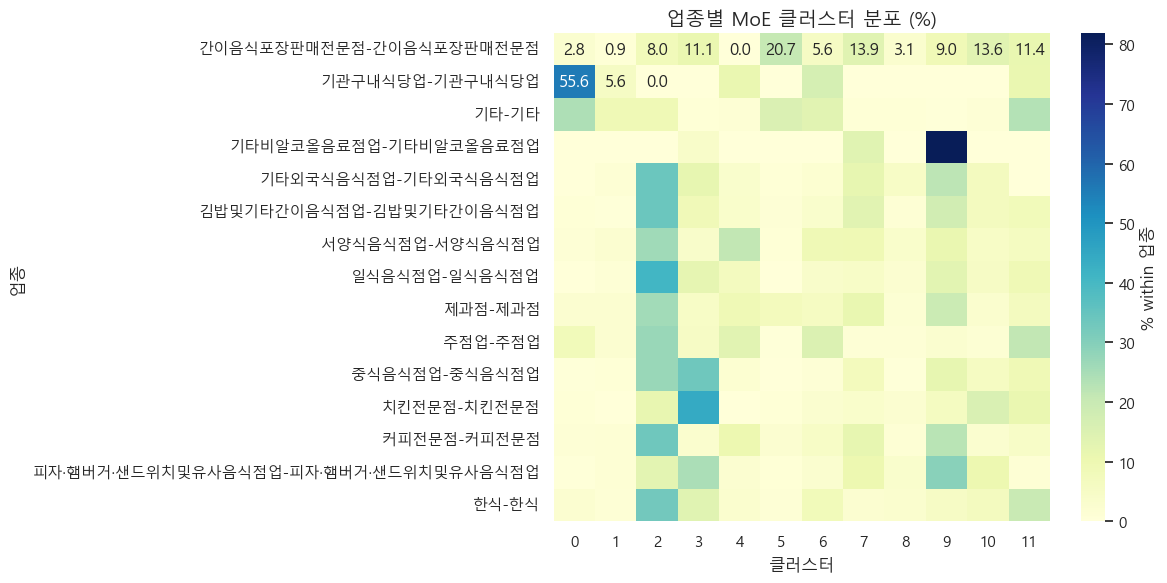

In [163]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 업종별 군집 분포 (%)
pivot_biz = (
    df_final.groupby(["biz_type_adj", "moe_cluster"])
    .size()
    .groupby(level=0)
    .apply(lambda x: x / x.sum() * 100)
    .unstack(fill_value=0)
)

plt.figure(figsize=(12, 6))
sns.heatmap(
    pivot_biz,
    annot=True, fmt=".1f", cmap="YlGnBu",
    cbar_kws={"label": "% within 업종"}
)
plt.title("업종별 MoE 클러스터 분포 (%)", fontsize=14)
plt.xlabel("클러스터")
plt.ylabel("업종")
plt.tight_layout()
plt.show()


### 8-2 상권군집

C:\Users\eunseok\AppData\Local\Temp\ipykernel_35040\1477229440.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_final.groupby(["market_adj", "moe_cluster"])
C:\Users\eunseok\AppData\Local\Temp\ipykernel_35040\1477229440.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(level=0)


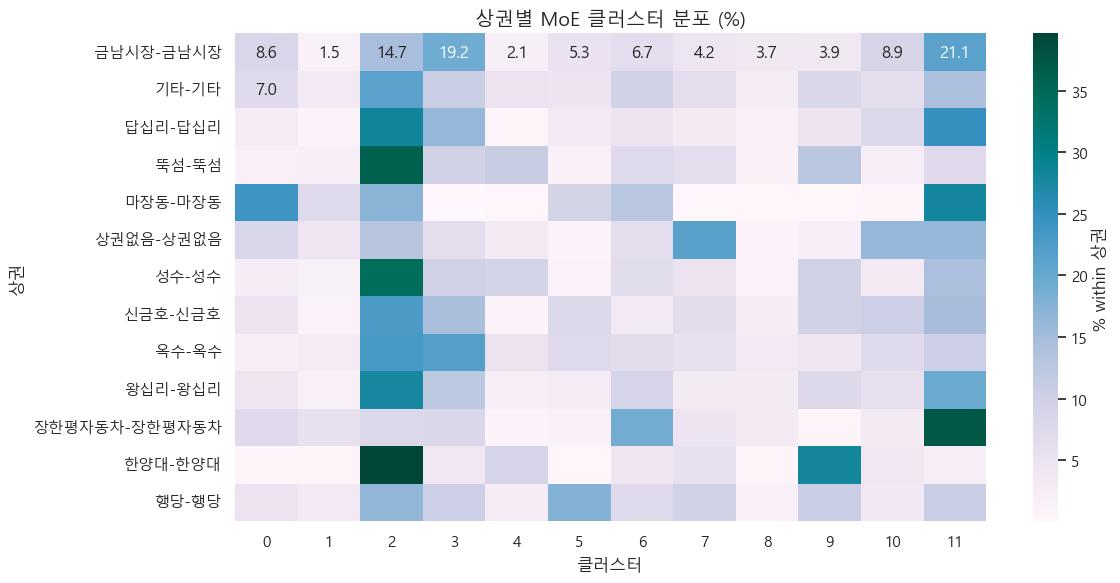

In [164]:
pivot_market = (
    df_final.groupby(["market_adj", "moe_cluster"])
    .size()
    .groupby(level=0)
    .apply(lambda x: x / x.sum() * 100)
    .unstack(fill_value=0)
)

plt.figure(figsize=(12, 6))
sns.heatmap(
    pivot_market,
    annot=True, fmt=".1f", cmap="PuBuGn",
    cbar_kws={"label": "% within 상권"}
)
plt.title("상권별 MoE 클러스터 분포 (%)", fontsize=14)
plt.xlabel("클러스터")
plt.ylabel("상권")
plt.tight_layout()
plt.show()


### 8-3 집계표 요약

In [165]:
summary = (
    df_final.groupby(["biz_type_adj", "market_adj", "moe_cluster"])
    .size()
    .reset_index(name="count")
)

# 업종 내 비율 계산
summary["prop_in_biz"] = (
    summary.groupby("biz_type_adj")["count"]
    .transform(lambda x: x / x.sum() * 100)
)

summary.sort_values(["biz_type_adj", "prop_in_biz"], ascending=[True, False]).head(20)


C:\Users\eunseok\AppData\Local\Temp\ipykernel_35040\3350577823.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_final.groupby(["biz_type_adj", "market_adj", "moe_cluster"])
C:\Users\eunseok\AppData\Local\Temp\ipykernel_35040\3350577823.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary.groupby("biz_type_adj")["count"]


,biz_type_adj,market_adj,moe_cluster,count,prop_in_biz
141,간이음식포장판매전문점,한양대,9,24,7.407407
17,간이음식포장판매전문점,기타,5,22,6.790123
151,간이음식포장판매전문점,행당,7,22,6.790123
3,간이음식포장판매전문점,금남시장,3,20,6.172840
22,간이음식포장판매전문점,기타,10,16,4.938272
14,간이음식포장판매전문점,기타,2,14,4.320988
19,간이음식포장판매전문점,기타,7,13,4.012346
38,간이음식포장판매전문점,뚝섬,2,12,3.703704
46,간이음식포장판매전문점,뚝섬,10,12,3.703704
89,간이음식포장판매전문점,신금호,5,12,3.703704


### 8-4 군집전이 확률

In [166]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40856 entries, 0 to 40855
Data columns (total 77 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   num                        40856 non-null  object  
 1   is_franchise               40856 non-null  int64   
 2   is_cold_start              40856 non-null  int64   
 3   target_ym                  40856 non-null  object  
 4   oper_month_grp_mean        40856 non-null  float64 
 5   avg_pay_grp_mean           40856 non-null  float64 
 6   cancel_rate_grp_mean       40856 non-null  float64 
 7   delivery_sales_ratio_mean  40856 non-null  float64 
 8   male_20below_ratio_mean    40856 non-null  float64 
 9   male_30_ratio_mean         40856 non-null  float64 
 10  male_40_ratio_mean         40856 non-null  float64 
 11  male_50_ratio_mean         40856 non-null  float64 
 12  male_60plus_ratio_mean     40856 non-null  float64 
 13  female_20below_ratio_mean  4085

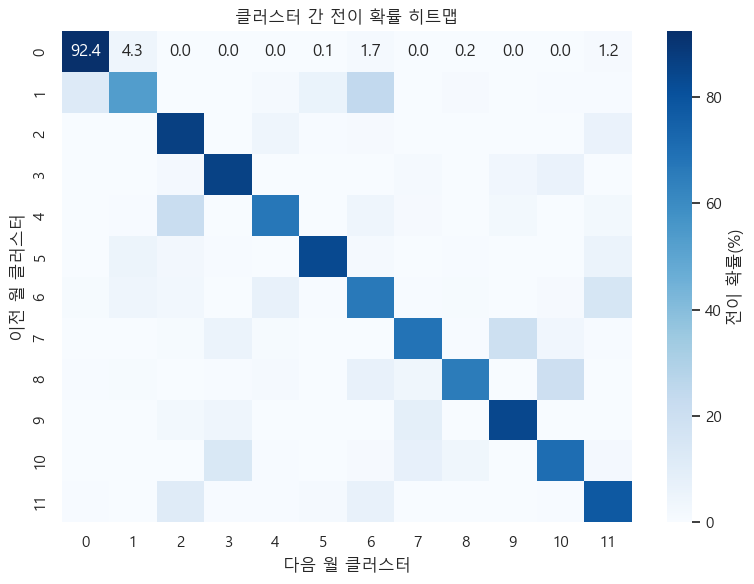

curr,0,1,2,3,4,5,6,7,8,9,10,11
prev,,,,,,,,,,,,
0,0.924,0.043,0.000,0.000,0.000,0.001,0.017,0.000,0.002,0.000,0.000,0.012
1,0.122,0.533,0.000,0.000,0.017,0.058,0.244,0.001,0.014,0.000,0.005,0.006
2,0.000,0.000,0.869,0.003,0.042,0.004,0.011,0.002,0.000,0.003,0.002,0.063
3,0.000,0.000,0.019,0.860,0.000,0.000,0.000,0.018,0.002,0.035,0.063,0.003
4,0.000,0.006,0.217,0.002,0.669,0.002,0.040,0.014,0.001,0.023,0.002,0.023
5,0.003,0.052,0.027,0.006,0.001,0.834,0.015,0.003,0.004,0.000,0.000,0.055
6,0.010,0.040,0.030,0.000,0.069,0.007,0.666,0.004,0.008,0.000,0.013,0.154
7,0.000,0.000,0.008,0.057,0.008,0.003,0.000,0.683,0.006,0.197,0.034,0.004
8,0.007,0.008,0.000,0.004,0.017,0.003,0.072,0.038,0.654,0.000,0.199,0.000


In [167]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# df_ews: EWS 계산까지 완료된 DataFrame
# 반드시 ['num', 'base_ym', 'moe_cluster'] 포함
# base_ym은 YYYYMM 또는 datetime 형태여야 함

# 월 단위 정렬
df_seq = df_final.sort_values(['num', 'target_ym'])

# 군집 전이 정보 계산
transitions = []
for num, g in df_seq.groupby('num'):
    g = g.sort_values('target_ym')
    prev = g['moe_cluster'].shift(1)
    curr = g['moe_cluster']
    for p, c in zip(prev, curr):
        if pd.notna(p) and pd.notna(c):
            transitions.append((int(p), int(c)))

trans_df = pd.DataFrame(transitions, columns=['prev', 'curr'])

# 전이 행렬 계산
transition_matrix = (
    trans_df.value_counts()
    .unstack(fill_value=0)
    .div(trans_df['prev'].value_counts(), axis=0)
    .fillna(0)
    .round(3)
)

# 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(
    transition_matrix * 100,
    cmap="Blues", annot=True, fmt=".1f",
    cbar_kws={'label': '전이 확률(%)'}
)
plt.title("클러스터 간 전이 확률 히트맵")
plt.xlabel("다음 월 클러스터")
plt.ylabel("이전 월 클러스터")
plt.tight_layout()
plt.show()

transition_matrix.head(12)


📊 전체 가맹점 수: 3,681
🔁 클러스터가 바뀐 가맹점 수: 2,629 (71.4%)
⚙️ 바뀌지 않은 가맹점 수: 1,052 (28.6%)


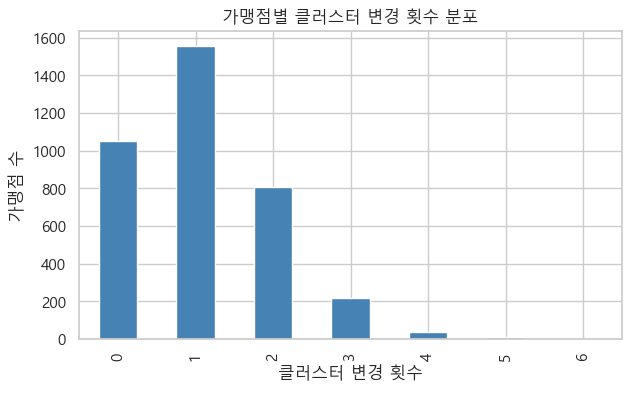

In [168]:
# 기준년월 정렬
df_final = df_final.sort_values(["num", "target_ym"])

# 가맹점별 클러스터 변화 여부 확인
cluster_change = (
    df_final.groupby("num")["moe_cluster"]
      .agg(["nunique", "count"])  # 각 점포의 고유 클러스터 수
      .rename(columns={"nunique": "고유클러스터수", "count": "관측개월"})
)

# 변경 횟수 = 고유 클러스터 수 - 1
cluster_change["클러스터_변경횟수"] = cluster_change["고유클러스터수"] - 1

# 변화 여부 flag
cluster_change["is_changed"] = (cluster_change["클러스터_변경횟수"] > 0).astype(int)

total_stores = cluster_change.shape[0]
changed_stores = cluster_change["is_changed"].sum()

print(f"📊 전체 가맹점 수: {total_stores:,}")
print(f"🔁 클러스터가 바뀐 가맹점 수: {changed_stores:,} ({changed_stores/total_stores*100:.1f}%)")
print(f"⚙️ 바뀌지 않은 가맹점 수: {total_stores - changed_stores:,} ({(1 - changed_stores/total_stores)*100:.1f}%)")

# --- 시각화 ---
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
cluster_change["클러스터_변경횟수"].value_counts().sort_index().plot(kind='bar', color='steelblue')
plt.title("가맹점별 클러스터 변경 횟수 분포")
plt.xlabel("클러스터 변경 횟수")
plt.ylabel("가맹점 수")
plt.show()


# 9. 새로운 데이터 클러스터 배정

In [169]:
import numpy as np
import pandas as pd

def assign_moe_for_new_using_existing(
    df_new: pd.DataFrame,
    X_cols: list,              # 훈련 때 확정된 X_cols
    Z_cols: list,              # ["biz_type_adj","market_adj","is_franchise","is_cold_start"]
    enc, gmm, gate,            # 훈련된 OneHotEncoder / GMM / LogisticRegression
    id_cols=("num","target_ym"),
    add_proba: bool = True,
):
    """
    (1) 기존 전처리 규칙으로 df_new를 df_final_new로 정리
    (2) 기존 X_cols/Z_cols 순서로 맞춰 타입 보정
    (3) enc/gmm/gate로 MoE 확률 결합 → hard label + (옵션) 확률 반환
    """
    # 1) 동일 규칙 전처리
    df_final_new = select_features_only(df_new)

    # 2) X/Z 구성 (부족한 열은 0/NA로 생성하여 순서 맞춤) + 타입 보정
    #    - X_cols는 훈련 기준으로 고정: df_new에 없으면 0으로 생성
    for c in X_cols:
        if c not in df_final_new.columns:
            df_final_new[c] = 0
    #    - Z_cols도 고정: 없으면 임시 NA 생성 (coerce_types_for_XZ에서 처리)
    for c in Z_cols:
        if c not in df_final_new.columns:
            df_final_new[c] = np.nan

    X_new, Z_new = coerce_types_for_XZ(df_final_new, X_cols, Z_cols)

    # 3) 인코딩 & 확률 계산
    Z_enc_new = enc.transform(Z_new)               # 훈련 OneHotEncoder
    gmm_proba  = gmm.predict_proba(X_new)          # (n, K)

    gate_raw   = gate.predict_proba(Z_enc_new)     # (n, K) but classes_ order
    order      = np.argsort(gate.classes_)         # 0..K-1 순으로 재정렬
    gate_proba = gate_raw[:, order]

    moe = gmm_proba * gate_proba
    denom = moe.sum(axis=1, keepdims=True)
    np.divide(moe, denom, out=moe, where=(denom != 0))
    moe_label = moe.argmax(axis=1)

    # 4) 출력 정리
    out = pd.DataFrame({"moe_cluster": moe_label}, index=df_new.index)
    if add_proba:
        for k in range(moe.shape[1]):
            out[f"moe_p_{k}"] = moe[:, k]

    # id 컬럼 붙이기(있을 때만)
    for c in id_cols:
        if c in df_new.columns:
            out[c] = df_new[c].values

    cols = ["moe_cluster"] + [c for c in id_cols if c in out] + [c for c in out.columns if c.startswith("moe_p_")]
    return out[cols]


In [170]:
# 전제: 아래 3개는 이미 네가 가진 함수들
# select_features_only, make_XZ_cols, coerce_types_for_XZ

# 전제: 훈련 때 확정된 스펙/객체
# X_cols, Z_cols, enc, gmm, gate

assigned_new = assign_moe_for_new_using_existing(
    df_new,
    X_cols=X_cols,
    Z_cols=Z_cols,              # ["biz_type_adj","market_adj","is_franchise","is_cold_start"]
    enc=enc, gmm=gmm, gate=gate,
    id_cols=("num","target_ym"),
    add_proba=True
)
assigned_new.head()


,moe_cluster,num,target_ym,moe_p_0,moe_p_1,moe_p_2,moe_p_3,moe_p_4,moe_p_5,moe_p_6,moe_p_7,moe_p_8,moe_p_9,moe_p_10,moe_p_11
0,8,000F03E44A,2024-09-01,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000
1,8,000F03E44A,2024-10-01,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000
2,8,000F03E44A,2024-11-01,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000
3,11,002816BA73,2024-09-01,0.0,1.866834e-46,8.659083e-23,7.718437e-43,2.566677e-155,5.174563e-152,3.847014e-16,1.175893e-105,3.735442e-51,0.000000e+00,1.647845e-23,1.000000
4,11,002816BA73,2024-10-01,0.0,1.140757e-46,7.479691e-06,1.517757e-25,7.257840e-139,3.083946e-120,5.584225e-17,7.188692e-70,1.350364e-51,1.726490e-195,3.768070e-24,0.999993


## 데이터 저장

In [171]:
import pandas as pd

# df에 클러스터만 병합
df_train_cluster = pd.merge(
    df,
    df_final[["num", "target_ym", "moe_cluster"]],
    on=["num", "target_ym"],
    how="left"
)

# CSV 저장
df_train_cluster.to_csv("train_cluster.csv", index=False, encoding="utf-8-sig")
print("✅ train_cluster.csv 저장 완료:", df_train_cluster.shape)


✅ train_cluster.csv 저장 완료: (40856, 111)


In [172]:
df_test_cluster = pd.merge(
    df_new,
    assigned_new[["num", "target_ym", "moe_cluster"]],
    on=["num", "target_ym"],
    how="left"
)

# CSV 저장
df_test_cluster.to_csv("test_cluster.csv", index=False, encoding="utf-8-sig")
print("✅ test_cluster.csv 저장 완료:", df_test_cluster.shape)

✅ test_cluster.csv 저장 완료: (11772, 112)
